In [1]:
#things to be import

import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.autograd as atgd
import torch.optim as optim
import torchvision

import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#loading training and testing data

batchsize = 16

transform = transforms.Compose(
    [
    transforms.Resize((32,32)),    
    transforms.ToTensor(),
    ])

train_dataset = torchvision.datasets.MNIST(root = './data/mnist', 
                           train = False, 
                           transform = transform,
                           download = True) 
test_dataset = torchvision.datasets.MNIST(root = './data/mnist',
                           train = True,
                           transform = transform,
                           download = True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batchsize,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batchsize,
                                          shuffle=True, num_workers=2)

print("The number of training images: ", len(train_loader)*batchsize)
print("The number of testing images: ", len(test_loader)*batchsize)


print("Data load OK!")

The number of training images:  10000
The number of testing images:  60000
Data load OK!


In [18]:
#Network structure

# # linear classifier
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(32*32, 10)
#     def forward(self, x):
#         x = x.view(-1, 32 * 32)
#         x= self.fc1(x)  
#         return x
# net = Net()


# # Network with only fc layers 
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(32*32, 16*16)
#         self.fc2 = nn.Linear(16*16, 8*8)
#         self.fc3 = nn.Linear(8*8, 10)

#     def forward(self, x):
#         x = x.view(-1, 32 * 32)
#         x = func.relu(self.fc1(x))
#         x = func.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
    
# net = Net()

# Network with 2 Conv2, 3fc
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 3)
#         self.conv3 = nn.Conv2d(16, 24, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*6*6, 10)
        
        
        
#         self.sm = nn.Softmax()
#         self.fc2 = nn.Linear(100, 64)
#         self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
#         print("1",x.size())
        x = self.pool(func.relu(self.conv1(x)))
#         print("2",x.size())
        x = self.pool(func.relu(self.conv2(x)))
#         x = self.pool(func.relu(self.conv3(x)))
#         print("3",x.size())
        x = x.view(-1, 16 * 6 * 6)
#         x = func.relu(self.fc1(x))
        x = self.fc1(x)
#         x = self.sm(self.fc1(x))
#         x = func.relu(self.fc2(x))
#         x = self.fc3(x)
        return x

net = Net()

print("Network Structure: ")
print(net)


# # Network with 2 Conv2, 3fc
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
# #         print("1",x.size())
#         x = self.pool(func.relu(self.conv1(x)))
# #         print("2",x.size())
#         x = self.pool(func.relu(self.conv2(x)))
# #         print("3",x.size())
#         x = x.view(-1, 16 * 5 * 5)
#         x = func.relu(self.fc1(x))
#         x = func.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# net = Net()
# print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Network Structure: 
Net(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=10, bias=True)
)


In [19]:
#training process

epoch_num = 5
x1 = range(1,epoch_num+1)
x2 = range(1,epoch_num+1)
accuracy1 = []
accuracy2 = []
loss1 = []
loss2 = []


for epoch in range(epoch_num): 
#     running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()     
        outputs = net(inputs)
        train_loss = criterion(outputs, labels)
        train_loss.backward()
        optimizer.step()
        
#         running_loss += train_loss.item()
#         if i % 1000 == 999:    
            
#     print("epoch number:%d, train_loss: %.3f" % (epoch + 1, running_loss / (len(train_loader)*batchsize) ))

    # training accuracy and loss

    print("epoch number %d" % (epoch + 1))
    
    correct = 0
    total = 0
    running_loss = 0
    for data in train_loader:
        images, labels = data
        outputs = net(images)
        
        train_loss = criterion(outputs, labels)
        running_loss += train_loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += batchsize
        correct += (predicted == labels).sum().item()
       
    print('train_accuracy: %.3f %%' % (100 * correct / total))
    accuracy1.append(100 * correct / total)
    print("train_loss: %.3f" % (running_loss / (len(train_loader)*batchsize) ))
    loss1.append(running_loss / (len(train_loader)*batchsize))
    
    # testing accuracy and loss
    correct = 0
    total = 0
    running_loss = 0
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        
        test_loss = criterion(outputs, labels)
        running_loss += test_loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += batchsize
        correct += (predicted == labels).sum().item()
       
    print('test_accuracy: %.3f %%' % (100 * correct / total))
    accuracy2.append(100 * correct / total)
    print("test_loss: %.3f" % (running_loss / (len(test_loader)*batchsize) ))
    loss2.append(running_loss / (len(test_loader)*batchsize))

print("Training OK!")





epoch number 1
train_accuracy: 86.810 %
train_loss: 0.027
test_accuracy: 85.272 %
test_loss: 0.030
epoch number 2
train_accuracy: 91.610 %
train_loss: 0.018
test_accuracy: 90.132 %
test_loss: 0.021
epoch number 3
train_accuracy: 93.520 %
train_loss: 0.014
test_accuracy: 91.715 %
test_loss: 0.017
epoch number 4
train_accuracy: 94.580 %
train_loss: 0.011
test_accuracy: 93.020 %
test_loss: 0.015
epoch number 5
train_accuracy: 95.370 %
train_loss: 0.009
test_accuracy: 93.863 %
test_loss: 0.013
Training OK!


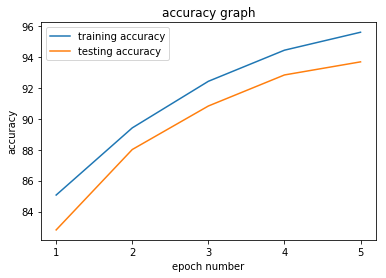

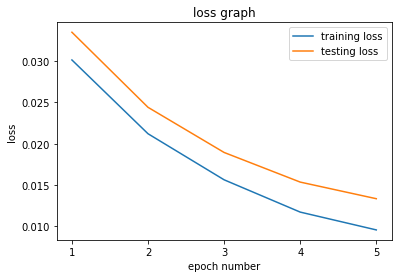

In [5]:
# visualize the result


plt.plot(x1, accuracy1, label="training accuracy")
plt.plot(x2, accuracy2, label="testing accuracy")
plt.xlabel("epoch number")
plt.xticks(np.linspace(1,epoch_num,epoch_num))
plt.ylabel("accuracy")
plt.title("accuracy graph")
plt.legend()
plt.show()


plt.plot(x1, loss1, label="training loss")
plt.plot(x2, loss2, label="testing loss")
plt.xlabel("epoch number")
plt.xticks(np.linspace(1,epoch_num,epoch_num))
plt.ylabel("loss")
plt.title("loss graph")
plt.legend()
plt.show()


In [6]:
# the acc for different numbers 

single_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                          shuffle=True, num_workers=2)

correct = [0.0]*10
total = [0.0]*10
# running_loss = 0
for data in single_loader:
    images, labels = data
    outputs = net(images)

#     test_loss = criterion(outputs, labels)
#     running_loss += test_loss.item()

    _, predicted = torch.max(outputs, 1)
    total[labels] += 1
    correct[labels] += (predicted == labels).sum().item()
    
    
# correct = 0
# total = 0
# running_loss = [0]*10
# number_cnt = [0]*10
# for data in single_loader:
#     images, labels = data
#     outputs = net(images)
#     test_loss = criterion(outputs, labels)
#     running_loss[labels] += test_loss.item()
#     number_cnt[labels] += 1
    
num_acc = []
for i in range(10):
    num_acc.append(100*correct[i]  / total[i])
    print("test_acc: %.3f" % (100*correct[i]  / total[i]))

test_acc: 93.432
test_acc: 96.826
test_acc: 95.653
test_acc: 88.746
test_acc: 93.547
test_acc: 95.259
test_acc: 96.215
test_acc: 93.472
test_acc: 90.925
test_acc: 92.537


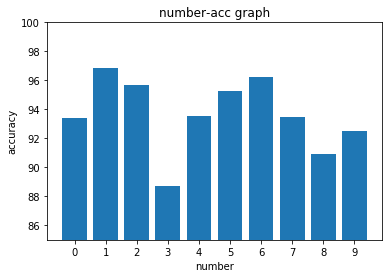

In [8]:
#visualize the result

num = range(0,10)
plt.bar(num, num_acc)

plt.xlabel("number")
plt.ylim((85,100))
plt.xticks(np.linspace(0,9,10))
plt.ylabel("accuracy")
plt.title("number-acc graph")

plt.show()

ground truth:  3 predicted result:  2


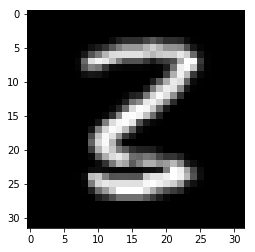

In [16]:
# find incorrect detection result

single_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                          shuffle=True, num_workers=2)


for data in single_loader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    
    if predicted != labels:
        plt.imshow(images.squeeze(), cmap = "gray")
        print("ground truth: ", labels.item(), "predicted result: ", predicted.item())
        break
        

    


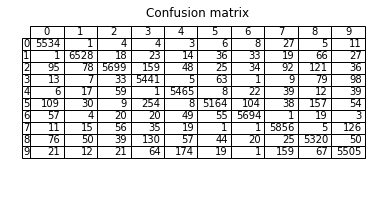

In [17]:
# output the confusion matrix 

single_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                          shuffle=True, num_workers=2)
cells = [([0]*10)for i in range(10)]

for data in single_loader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)

    cells[predicted.item()][labels.item()] += 1


labels_num = [i for i in range(10)]
predicted_num = [i for i in range(10)]


plt.subplot2grid((4,3), (0,0), colspan=5, rowspan=3)
plt.axis("off")
plt.table(rowLabels = predicted_num, colLabels = labels_num ,cellText = cells,loc="upper center",
         colWidths= [0.1]*10)
plt.title("Confusion matrix")
plt.show()
